# **Finetune LLMs for Free: A Step-by-Step Open-Source Tutorial**

**Welcome to this tutorial!** In the following steps, we will show you how to fine-tune the llama-2 7B LLM for **Question Answering** on your own private data. Simply run the cells sequentially, to learn how to load the model and your data, train the model, and finally ask questions about your data.

### Why would this tutorial be helpful for you?

Our tutorial to fine-tune llama 2 uniquely offers several advantages over others currently out in the internet, namely:

1. The ability to **fine-tune on freeform text articles and documents**; we don't assume you manually format your data in well defined formats like CSV, JSON, etc.

2. Offer **greater degree of control** and **in-depth explanations** to users on tuning parameters to **optimize performance of fine-tuned model** specific for your use case

3. Provide a **walkthrough of fine-tuning Llama-2 with high accuracy and demonstration** of this model based on a **realistic use case**.

#### Authors and Credits

[Sri Ranganathan Palaniappan](https://www.linkedin.com/in/sri-ranganathan-palaniappan/), CS undergrad student at Georgia Tech.

[Mansi Phute](https://www.linkedin.com/in/mansi-phute-413744166/),  CS masters student at Georgia Tech

[Seongmin Lee](https://www.linkedin.com/in/seongmin-lee-8b8a97209/),  CS PhD student at Georgia Tech

[Polo Chau](https://www.linkedin.com/in/polochau/),  Associate Professor at Georgia Tech.

**Memory requirements: How many GPU(s) to use?**

This tutorial needs no more than 14GB GPU RAM. Depending on the GPU you’re using, one GPU may be sufficient (e.g., NVIDIA RTX 4090 has 24GB RAM). Modify the code below to specify the number of GPUs to use.

Refer to this [medium post](https://medium.com/polo-club-of-data-science/memory-requirements-for-fine-tuning-llama-2-80f366cba7f5) to learn more about the memory requirements for finetuning Llama-2-7B!

**Note: If you're using Google Colab, the code below automatically sets the GPU to T4.**

In [ ]:
!pip install GPUtil
import GPUtil
import os

GPUtil.showUtilization()



  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=d286d40d270a3e09dd6c03ac1419f0567a55b701d2a3dbaf4f7acd84d681df9b
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


## Import Libraries

Execute the cell below to import the necessary libraries for fine-tuning Llama-2.

**Note:** *You only need to run this cell once initially, and you can then comment it out.*


In [ ]:
#!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q transformers
!pip install -q datasets
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [ ]:
#!pip install git+https://github.com/huggingface/peft.git
!pip install -q peft==0.10.0



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install -q transformers
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU ID (0 for T4)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import torch
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU not available.")


# Change if needed to accomodate memory requirements!

!nvidia-smi # Verify notebook is running on a GPU
print(os.environ)

GPU is available!
Fri Apr 11 16:39:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

In [ ]:

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import load_dataset
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datetime import datetime

if 'COLAB_GPU' in os.environ:
    from google.colab import output
    output.enable_custom_widget_manager()

## **Load and Configure Model**

**Since Llama-2 is a gated model, do the following steps to get access to the model:**

**1. Create an account in HuggingFace [here](https://huggingface.co/join)**

**2. Request access to the [Llama-2-7b-chat model here](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf).**

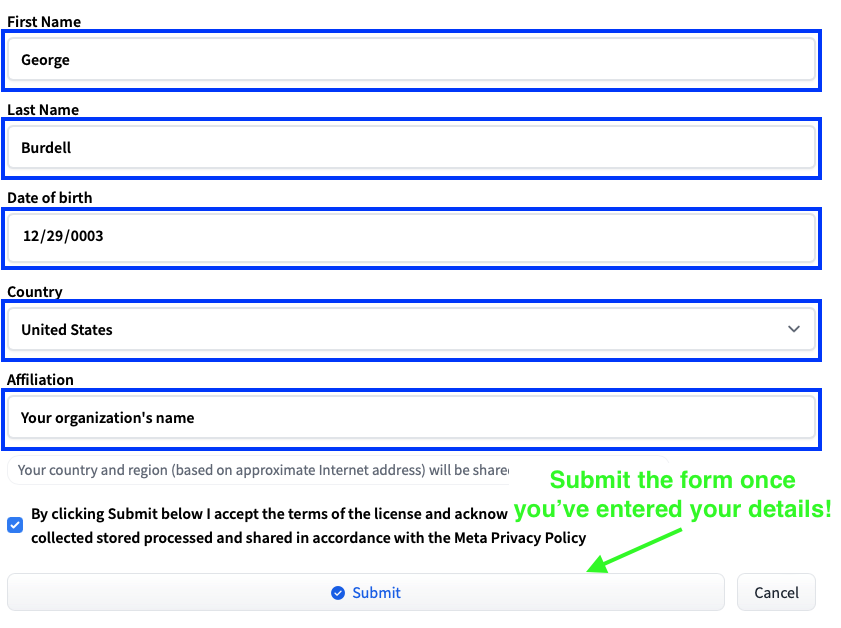

**Once you fill out the form as instructed above, you should get an email confirmation granting access to the model. You're good to proceed with the tutorial!**

We load the model from Hugging Face using **4-bit quantization** with the [`BitsAndBytesConfig`](https://huggingface.co/docs/transformers/main_classes/quantization#transformers.BitsAndBytesConfig)
 from the Hugging Face Transformers library.


In [ ]:
if 'COLAB_GPU' in os.environ:
    !huggingface-cli login
else:
    notebook_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `JUNKO` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pus

In [ ]:
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)

'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             quantization_config=bnb_config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

## Loading datasets for training

<!-- For fine-tuning Llama-2-7b-chat model on your own private data, depending on the usecases, the format of your input data plays a significant role in the training process. In this guide, we'll explore two common formats for organizing your data: **JSON for structured data and text (.txt) for unstructured data**. -->

<!-- ### **Option 1: Structured Data (JSON Format)**

JSON formatted input data provides a structured format consisting of question-answer pairs. Each datapoint (each line) consists of a question and its corresponding answer, allowing for clear and explicit mapping of question-answer pairs. This format is ideal for scenarios where data is neatly organized and follows a predictable structure.

**Pros:**
- Clear and organized structure, resulting in better training results.
- Explicit mapping for question with corresponding answer.
- Suitable for datasets with consistent formatting.

**Cons:**
- Labor intensive: requires additional processing to convert unstructured data into a structured format.
- Less flexible for datasets with varying or irregular structures. -->

<!-- ### **Loading data as multiple .txt files** -->
### **Unstructured Data (Text Format)**

**Pros:**
- Flexible with diverse data formats with irregular structures, not limited to Question-Answer pairs.
- Can contain blocks of text from guides/articles or multiple Q&A pairs.
- Simple to create and modify; offers enhanced readability and reduced labor intensity.

**Cons:**
- Compared to JSON format, offers less structured data, potentially resulting in inferior training outcomes.


All of our training data are formatted as **multiple .txt files**.


`train_dataset`: *Important for model training, this dataset contains the training data used to update the model’s weights through backpropagation.*

We have provided example training .txt files cloned from a github repository that shows how your private data may be formatted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pathToData = "/content/drive/MyDrive/Colab Notebooks/data/plans" #text files
output = "/content/drive/MyDrive/Colab Notebooks/data/data.json" #amalgamated

In [ ]:
import glob
import json

filepaths = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/plans/*.txt")
print(len(filepaths))
line = []
data = []
lineNo = 0
count = 0
for filepath in filepaths:
    print(str(count) + " " + filepath)
    question = ""
    answer = ""
    if "txt" in filepath:
      with open(filepath) as fp:
          for cnt, line in enumerate(fp.readlines()):
            if (cnt <= 7):
              question = question + line
            else:
              answer = answer + line
          question += "- \n"
          answer = answer.replace('"', "")
          question = question.replace('"', "")
          data.append({"Question": " ".join(question.split()), "Answer": " ".join((question + answer).split())});
      count+=1

with open(output, 'a') as outfile:
  for i in range(len(data)):
    json.dump(data[i], outfile)
    outfile.write('\n')

Streaming output truncated to the last 5000 lines.
6930 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134136.txt
6931 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134159.txt
6932 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134182.txt
6933 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134205.txt
6934 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134228.txt
6935 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134251.txt
6936 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134274.txt
6937 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134297.txt
6938 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134320.txt
6939 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134343.txt
6940 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_134366.txt
6941 /content/drive/MyDrive/Colab Notebooks/data/plans/Gambling_plan_

In [ ]:
#!git clone https://github.com/poloclub/Fine-tuning-LLMs.git

if 'COLAB_GPU' in os.environ:
    dir_path = '/content/drive/MyDrive/Colab Notebooks/data/'
else:
    dir_path = 'drive/MyDrive/Colab Notebooks/data/'

os.chdir(dir_path)
files = []

plans = []
for filename in os.listdir(dir_path):
    path = os.path.join(dir_path, filename)
    print(path)
    if not os.path.basename(path).startswith(".") and not path == "C:/Users/Ben/Desktop/work/aisetup/data/plans" and ".txt" in filename and "out" not in filename:
        plans.append(filename)

# import random
# plans = random.sample(plans, 350)

# plans.append("structure.txt")
print(plans)
train_dataset = load_dataset("text", data_files={"train":
                plans}, split='train')

os.chdir('..')
os.chdir('..')

/content/drive/MyDrive/Colab Notebooks/data/common triggers for pornography watchers.txt
/content/drive/MyDrive/Colab Notebooks/data/common triggers for smokers.txt
/content/drive/MyDrive/Colab Notebooks/data/common triggers for alcoholics.txt
/content/drive/MyDrive/Colab Notebooks/data/common triggers for gamblers.txt
/content/drive/MyDrive/Colab Notebooks/data/common triggers for internet addicts.txt
/content/drive/MyDrive/Colab Notebooks/data/basic structure.txt
/content/drive/MyDrive/Colab Notebooks/data/plans
/content/drive/MyDrive/Colab Notebooks/data/alcohol.txt
/content/drive/MyDrive/Colab Notebooks/data/gambling.txt
/content/drive/MyDrive/Colab Notebooks/data/internet.txt
/content/drive/MyDrive/Colab Notebooks/data/pornography.txt
/content/drive/MyDrive/Colab Notebooks/data/smoking.txt
/content/drive/MyDrive/Colab Notebooks/data/data.csv
/content/drive/MyDrive/Colab Notebooks/data/out.txt
['common triggers for pornography watchers.txt', 'common triggers for smokers.txt', 'comm

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(len(plans))

11


### **Initialize & configure tokenizer**

We have set `add_eos_token = True` so that the model knows how to recognize the “end of sentence". We have also added a special pad token `'[PAD]'` to pad shorter lines to match the length of longer ones.

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True,
                                           add_eos_token=True)

'''
We initialize the Llama tokenizer (slow) for the Llama-2-7b-chat model.
The Llama tokenizer is known to have issues with automatically setting
the End-of-sentence (eos) token and the padding (pad) token.
'''

if tokenizer.pad_token is None:
    print("ah")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# set the pad token to indicate that it's the end-of-sentence
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

ah


### **Tokenize Prompt for formatted data**

We tokenize—converting text into numbers to make it understandable for LLMs—our training dataset using the code below:


In [ ]:
tokenized_train_dataset=[]
for phrase in train_dataset:
    tokenized_train_dataset.append(tokenizer(phrase['text']))

NameError: name 'train_dataset' is not defined

### ***Bonus Option: Structured data (JSONL format)***

*You can also finetune your model on structured data which is formatted as JSONL files! Each datapoint (each line) consists of a question and its corresponding answer, allowing for clear and explicit mapping of question-answer pairs, thus leading to **better training results**.*

*Each line is a datapoint that is formatted as:*

```json
{'Question': 'Your question goes here', 'Answer': 'Your answer goes here'}
```

*However, this format is **labor intensive and only ideal for scenarios where data is exclusively Q&A pairs** neatly organized and follows a predictable structure.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pathToData = "/content/drive/MyDrive/Colab Notebooks/data/plans" #text files
output = "/content/drive/MyDrive/Colab Notebooks/data/data.json" #amalgamated

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU ID (0 for T4)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
#!pip install git+https://github.com/huggingface/peft.git
!pip install -q peft==0.10.0
!pip install -U bitsandbytes
!pip install -q transformers
!pip install -q datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

#import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from huggingface_hub import notebook_login
from datasets import load_dataset
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datetime import datetime

if 'COLAB_GPU' in os.environ:
    from google.colab import output
    output.enable_custom_widget_manager()

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF']="expandable_segments:True"

import torch
import transformers

from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

In [ ]:
!huggingface-cli login
from transformers import BitsAndBytesConfig,LlamaTokenizer
model_id = "/content/drive/MyDrive/Colab-Notebooks/junkospit"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)
'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(model_id)
#model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.float32, device_map="cuda:0") # Must be float32 for MacBooks!
tokenizer = AutoTokenizer.from_pretrained(model_id)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
from transformers import pipeline
#model_id = "/content/drive/MyDrive/Colab-Notebooks/junkospit"
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
)

#pipe = pipeline(task="text-generation", model=model_id, tokenizer=tokenizer, max_length=200)
messages = [
    {"role": "user", "content": "Addiction name: Pornography Triggers: - late night - horny - lonliness Addiction Severity: 0.7 Warning Signs: -"},
]

outputs = pipe(
    messages,
    max_new_tokens=128
)
print(pipe)
print("OUTPUT:")
print(outputs[0]["generated_text"][-1])

Device set to use cpu


OUTPUT:
{'role': 'assistant', 'content': ' Addiction name: Pornography Triggers: - late night - horny - lonliness Addiction Severity: 0.7 Warning Signs: - - time has reached midnight - sexual urges - isolation Coping Strategies: - limit screen time - block websites - exercise '}


In [ ]:
pipe.push_to_hub("RosalinaS/Junko")

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/RosalinaS/Junko/commit/9c746d1d2043a6a4cb6b22231ffaf2c01f5ab2a8', commit_message='Upload TextGenerationPipeline', commit_description='', oid='9c746d1d2043a6a4cb6b22231ffaf2c01f5ab2a8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/RosalinaS/Junko', endpoint='https://huggingface.co', repo_type='model', repo_id='RosalinaS/Junko'), pr_revision=None, pr_num=None)

In [ ]:
base_model_id = "meta-llama/Llama-2-7b-chat-hf"
!huggingface-cli login
from transformers import BitsAndBytesConfig,LlamaTokenizer
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)

model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.pad_token = tokenizer.eos_token

# gradient checkpointing to reduce memory usage for increased compute time
model.gradient_checkpointing_enable()

# compressing the base model into a smaller, more efficient model
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    # rank of the update matrices
    # Lower rank results in smaller matrices with fewer trainable params
    r=8,

    # impacts low-rank approximation aggressiveness
    # increasing value speeds up training
    lora_alpha=64,

    # modules to apply the LoRA update matrices
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "down_proj",
        "up_proj",
        "o_proj"
    ],

    # determines LoRA bias type, influencing training dynamics
    bias="none",

    # regulates model regularization; increasing may lead to underfitting
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

# Load the training dataset
dataset = load_dataset("json", data_files=output, split="train")

# Define a function to apply the chat template
def apply_chat_template(example):
    messages = [
        {"role": "user", "content": example['Question']},
        {"role": "assistant", "content": example['Answer']}
    ]
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    return {"prompt": prompt}

# Apply the chat template function to the dataset
new_dataset = dataset.map(apply_chat_template)
new_dataset = new_dataset.train_test_split(0.8) # Let's keep 5% of the data for testing
small_dataset = new_dataset['train'].train_test_split(0.05)

# Tokenize the data
def tokenize_function(example):
    tokens = tokenizer(example['prompt'], padding="max_length", truncation=True, max_length=128)
    # Set padding token labels to -100 to ignore them in loss calculation
    tokens['labels'] = [
        -100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']
    ]
    return tokens

# Apply tokenize_function to each row
tokenized_dataset = new_dataset.map(tokenize_function)
tokenized_dataset = tokenized_dataset.remove_columns(['Question', 'Answer', 'prompt'])
small_tokenized_dataset = small_dataset.map(tokenize_function)
small_tokenized_dataset = small_tokenized_dataset.remove_columns(['Question', 'Answer', 'prompt'])

# Define training arguments
model.train()
training_args = transformers.TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/results",
    eval_strategy="steps", # To evaluate during training
    eval_steps=40,
    logging_steps=40,
    save_steps=150,
    per_device_train_batch_size=2, # Adjust based on your hardware
    per_device_eval_batch_size=2,
    num_train_epochs=2, # How many times to loop through the dataset
    fp16=False, # Must be False for MacBooks
    report_to="none", # Here we can use something like tensorboard to see the training metrics
    log_level="info",
    learning_rate=1e-5, # Would avoid larger values here
    max_grad_norm=2 # Clipping the gradients is always a good idea
)

# Initialize Trainer
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=small_tokenized_dataset["test"],
    tokenizer=tokenizer)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

TypeError: 'module' object is not iterable

In [ ]:
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/junkospit")
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/junkospit")

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/junkospit
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.50.3",
  "use_cache": true,
  "vocab_size": 32000
}

tokenizer config file saved in /conte

('/content/drive/MyDrive/Colab Notebooks/junkospit/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/junkospit/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/junkospit/tokenizer.model',
 '/content/drive/MyDrive/Colab Notebooks/junkospit/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/junkospit/tokenizer.json')

In [ ]:


base_model_id = "meta-llama/Llama-2-7b-chat-hf"
!huggingface-cli login
from transformers import BitsAndBytesConfig,LlamaTokenizer
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     low_cpu_mem_usage=True
# )
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)
'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config)
#model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.float32, device_map="cuda:0") # Must be float32 for MacBooks!
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

# gradient checkpointing to reduce memory usage for increased compute time
model.gradient_checkpointing_enable()

# compressing the base model into a smaller, more efficient model
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    # rank of the update matrices
    # Lower rank results in smaller matrices with fewer trainable params
    r=8,

    # impacts low-rank approximation aggressiveness
    # increasing value speeds up training
    lora_alpha=64,

    # modules to apply the LoRA update matrices
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "down_proj",
        "up_proj",
        "o_proj"
    ],

    # determines LoRA bias type, influencing training dynamics
    bias="none",

    # regulates model regularization; increasing may lead to underfitting
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

# Load the training dataset
dataset = load_dataset("json", data_files=output, split="train")

# Define a function to apply the chat template
def apply_chat_template(example):
    messages = [
        {"role": "user", "content": example['Question']},
        {"role": "assistant", "content": example['Answer']}
    ]
    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    return {"prompt": prompt}

# Apply the chat template function to the dataset
new_dataset = dataset.map(apply_chat_template)
new_dataset = new_dataset.train_test_split(0.8) # Let's keep 5% of the data for testing
small_dataset = new_dataset['train'].train_test_split(0.05) # Let's keep 5% of the data for testing

# Tokenize the data
def tokenize_function(example):
    tokens = tokenizer(example['prompt'], padding="max_length", truncation=True, max_length=128)
    # Set padding token labels to -100 to ignore them in loss calculation
    tokens['labels'] = [
        -100 if token == tokenizer.pad_token_id else token for token in tokens['input_ids']
    ]
    return tokens

# Apply tokenize_function to each row
tokenized_dataset = new_dataset.map(tokenize_function)
tokenized_dataset = tokenized_dataset.remove_columns(['Question', 'Answer', 'prompt'])
small_tokenized_dataset = small_dataset.map(tokenize_function)
small_tokenized_dataset = small_tokenized_dataset.remove_columns(['Question', 'Answer', 'prompt'])

# Define training arguments
model.train()
training_args = transformers.TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/results",
    eval_strategy="steps", # To evaluate during training
    eval_steps=40,
    logging_steps=40,
    save_steps=150,
    per_device_train_batch_size=2, # Adjust based on your hardware
    per_device_eval_batch_size=2,
    num_train_epochs=2, # How many times to loop through the dataset
    fp16=False, # Must be False for MacBooks
    report_to="none", # Here we can use something like tensorboard to see the training metrics
    log_level="info",
    learning_rate=1e-5, # Would avoid larger values here
    max_grad_norm=2 # Clipping the gradients is always a good idea
)

# Initialize Trainer
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=small_tokenized_dataset["test"],
    tokenizer=tokenizer)

trainer.push_to_hub()

# Train the model
#trainer.train()

# Save the model and tokenizer
# trainer.save_model("./fine-tuned-model")
# tokenizer.save_pretrained("./fine-tuned-model")


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/11930 [00:00<?, ? examples/s]

Map:   0%|          | 0/2386 [00:00<?, ? examples/s]

Map:   0%|          | 0/9544 [00:00<?, ? examples/s]

Map:   0%|          | 0/2266 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

<ipython-input-21-7608e8bbfdf7>:121: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = transformers.Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/results
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--meta-llama--Llama-2-7b-chat-hf/snapshots/f5db02db724555f92da89c216ac04704f23d4590/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermed

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/RosalinaS/results/commit/9586912890a02679c2869f3a389448183707c7b2', commit_message='End of training', commit_description='', oid='9586912890a02679c2869f3a389448183707c7b2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/RosalinaS/results', endpoint='https://huggingface.co', repo_type='model', repo_id='RosalinaS/results'), pr_revision=None, pr_num=None)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.cuda.device_ids()) #it shows all GPU's ids.

AttributeError: module 'torch.cuda' has no attribute 'device_ids'

In [ ]:
import torch
from transformers import pipeline
!huggingface-cli login
model_id = "/content/drive/MyDrive/Colab-Notebooks/junkospit"
pipe = pipeline(
    "text-generation",
    model=model_id,
    device_map="auto",
)
messages = [
    {"role": "user", "content": "Addiction name: Pornography Triggers: - late night - horny - lonliness Addiction Severity: 0.7 Warning Signs: -"},
]

outputs = pipe(
    messages,
    max_new_tokens=128
)
print(pipe)
print("OUTPUT:")
print(outputs[0]["generated_text"][-1])


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for model.layers.13.self_attn.q_proj.lora_A.default.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for model.layers.13.self_attn.q_proj.lora_B.default.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for model.layers.13.self_attn.k_proj.lora_A.default.weight: 

NotImplementedError: Cannot copy out of meta tensor; no data!

In [ ]:
torch.save(pipe.model.state_dict(), "/content/drive/MyDrive/Colab-Notebooks/junkospit/junko.pth")

In [ ]:
print(pipe.model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): 

In [ ]:
import torch
from torch.export import export, ExportedProgram


class SimpleConv(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, padding=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        a = self.conv(x)
        return self.relu(a)


example_args = (torch.randn(1, 3, 256, 256),)
aten_dialect: ExportedProgram = export(SimpleConv(), example_args)
print(aten_dialect)

ExportedProgram:
    class GraphModule(torch.nn.Module):
        def forward(self, p_conv_weight: "f32[16, 3, 3, 3]", p_conv_bias: "f32[16]", x: "f32[1, 3, 256, 256]"):
             # File: <ipython-input-7-fe7b9deedc38>:14 in forward, code: a = self.conv(x)
            conv2d: "f32[1, 16, 256, 256]" = torch.ops.aten.conv2d.default(x, p_conv_weight, p_conv_bias, [1, 1], [1, 1]);  x = p_conv_weight = p_conv_bias = None
            
             # File: <ipython-input-7-fe7b9deedc38>:15 in forward, code: return self.relu(a)
            relu: "f32[1, 16, 256, 256]" = torch.ops.aten.relu.default(conv2d);  conv2d = None
            return (relu,)
            
Graph signature: ExportGraphSignature(input_specs=[InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_conv_weight'), target='conv.weight', persistent=None), InputSpec(kind=<InputKind.PARAMETER: 2>, arg=TensorArgument(name='p_conv_bias'), target='conv.bias', persistent=None), InputSpec(kind=<InputKind.USER_INPUT: 1>, ar

In [ ]:
!huggingface-cli login
from transformers import BitsAndBytesConfig,LlamaTokenizer
model_id = "/content/drive/MyDrive/Colab-Notebooks/junkospit"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)
'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config)
#model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.float32, device_map="cuda:0") # Must be float32 for MacBooks!
tokenizer = AutoTokenizer.from_pretrained(model_id)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write

ImportError: Using `bitsandbytes` 4-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [ ]:
from torch.export import Dim


class Basic(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return x + y


example_args = (torch.randn(3, 3), torch.randn(3, 3))
dim1_x = Dim("dim1_x", min=1, max=10)
dynamic_shapes = {"x": {1: dim1_x}, "y": {1: dim1_x}}
aten_dialect: ExportedProgram = export(
    Basic(), example_args, dynamic_shapes=dynamic_shapes
)
print(aten_dialect)

ExportedProgram:
    class GraphModule(torch.nn.Module):
        def forward(self, x: "f32[3, s0]", y: "f32[3, s0]"):
             # File: <ipython-input-11-e42e20872e3b>:9 in forward, code: return x + y
            add: "f32[3, s0]" = torch.ops.aten.add.Tensor(x, y);  x = y = None
            return (add,)
            
Graph signature: ExportGraphSignature(input_specs=[InputSpec(kind=<InputKind.USER_INPUT: 1>, arg=TensorArgument(name='x'), target=None, persistent=None), InputSpec(kind=<InputKind.USER_INPUT: 1>, arg=TensorArgument(name='y'), target=None, persistent=None)], output_specs=[OutputSpec(kind=<OutputKind.USER_OUTPUT: 1>, arg=TensorArgument(name='add'), target=None)])
Range constraints: {s0: VR[1, 10]}



In [ ]:
!pip install executorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.7/495.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 47.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
!build_llama_binary.sh --model-path /content/drive/MyDrive/Colab Notebooks/junkospit --params-path /content/drive/MyDrive/Colab Notebooks/junkospit

/bin/bash: line 1: build_llama_binary.sh: command not found


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/junkospit/model.pth")

In [ ]:
!install_executorch.sh --pybind xnnpack

/bin/bash: line 1: install_executorch.sh: command not found


In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    low_cpu_mem_usage=True
)
'''
NOTE:


load_in_4bit: Enables loading the model using 4-bit quantization, reducing
memory and computational costs.

bnb_4bit_compute_dtype: Sets the computational data type for the 4-bit quantized
model, controlling precision during inference or training.
'''

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             quantization_config=bnb_config)
#model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.float32, device_map="cuda:0") # Must be float32 for MacBooks!
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.trainer.push_to_hub(model, use_temp_dir=False)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: 'LlamaForCausalLM' object has no attribute 'trainer'

In [ ]:
######### UNCOMMENT CODE BELOW IF INPUT DATA IS JSONL FILES ##########

## Load dataset

from datasets import load_dataset


train_dataset = load_dataset("json", data_files={"train":
  [output]}, split="train")

train_dataset = train_dataset.train_test_split(test_size=0.82, seed=42)

def formatInputJSONData(datapoint):
    print(datapoint)
    text = f"{datapoint['Question']}\n{datapoint['Answer']}"
    return text

## Tokenize data

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
   trust_remote_code=True, add_eos_token=True)

if tokenizer.pad_token is None:
    print("ah")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

## Tokenize prompt

def tokenizePrompt(prompt):
    currPrompt = formatInputJSONData(prompt)
    return tokenizer(currPrompt)


tokenized_train_dataset = train_dataset.map(tokenizePrompt)
print(tokenized_train_dataset)

######### UNCOMMENT CODE ABOVE IF INPUT DATA IS JSONL FILES ##########

ah


Map:   0%|          | 0/2147 [00:00<?, ? examples/s]

{'Question': 'Addiction name: Gambling Triggers: - availability of online gambling platforms - social influence from gambling peers - watching gambling advertisements Addiction Severity: 0.3 Warning Signs: -', 'Answer': 'Addiction name: Gambling Triggers: - availability of online gambling platforms - social influence from gambling peers - watching gambling advertisements Addiction Severity: 0.3 Warning Signs: - - trouble focusing - making excuses - neglecting bills Coping Strategies: - maintain a budget - set specific savings goals and reward progress - attend support groups'}
{'Question': 'Addiction name: Gambling Triggers: - celebrating - media that glamourizes gambling - significant loss Addiction Severity: 0.5 Warning Signs: -', 'Answer': "Addiction name: Gambling Triggers: - celebrating - media that glamourizes gambling - significant loss Addiction Severity: 0.5 Warning Signs: - - secrecy - reclusion - emotional swings Coping Strategies: - keep excess cash in an inaccessible accou

Map:   0%|          | 0/9783 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
{'Question': 'Addiction name: Gambling Triggers: - the need to flex - feeling bored - fomo Addiction Severity: 0.5 Warning Signs: -', 'Answer': 'Addiction name: Gambling Triggers: - the need to flex - feeling bored - fomo Addiction Severity: 0.5 Warning Signs: - - insecurity - feeling pressured to gamble - having no plans Coping Strategies: - exercise to develop confidence in yourself - create plans for yourself and involve others - focus on demonstrating progress not through money'}
{'Question': 'Addiction name: Pornography Triggers: - boredom - loneliness - tiredness Addiction Severity: 0.2 Warning Signs: -', 'Answer': 'Addiction name: Pornography Triggers: - boredom - loneliness - tiredness Addiction Severity: 0.2 Warning Signs: - - time has reached early morning - isolation - sexual urges Coping Strategies: - blockers - limit screen time - exercise'}
{'Question': 'Addiction name: Gambling Triggers: - retirement - interest in solvin

### **PEFT Fine-Tuning**

We now prepare the model for knowledge distillation training using the **PEFT (Parameter-Efficient Fine-Tuning)** method to significantly reduce the memory and compute requirements.


In [ ]:
# gradient checkpointing to reduce memory usage for increased compute time
model.gradient_checkpointing_enable()

# compressing the base model into a smaller, more efficient model
model = prepare_model_for_kbit_training(model)

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32001, 4096)

### Configure model with LoRA

The code below uses [LoRA](https://huggingface.co/docs/diffusers/en/training/lora) (a PEFT method) to reduce the number of trainable parameters. LoRA works by decomposing the large matrix of the pre-trained model into two smaller low-rank matrices in the attention layers which drastically reduces the number of parameters that need to be fine-tuned. Refer to the __[LoRA documentation](https://opendelta.readthedocs.io/en/latest/modules/deltas.html#lora)__ to learn more about the parameters and use cases.

In [ ]:
config = LoraConfig(
    # rank of the update matrices
    # Lower rank results in smaller matrices with fewer trainable params
    r=8,

    # impacts low-rank approximation aggressiveness
    # increasing value speeds up training
    lora_alpha=64,

    # modules to apply the LoRA update matrices
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "gate_proj",
        "down_proj",
        "up_proj",
        "o_proj"
    ],

    # determines LoRA bias type, influencing training dynamics
    bias="none",

    # regulates model regularization; increasing may lead to underfitting
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

## Training the model

We're now ready to train our Llama 2 model on our new data! We'll be using the [`Transformers`](https://huggingface.co/docs/transformers/en/index) library to create a [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) object for training the model. The `Trainer` takes the pre-trained model, training datasets, training arguments, and data collator as input.

Training time depends on the size of the training data, number of epochs and the configuration of the GPU used. If you run the below cell using the sample dataset provided on Google Colab T4 GPU (default), then it should take around **1 hour 30 minutes to complete training** for 3 epochs of the provided sample Hawaii wildfire dataset.

In [ ]:
### TWO IMPORTANT TRAINING PARAMETERS TO CONSIDER CHANGING


train_epochs_val = 2 # CHANGE VALUE AS NEEDED HERE!
'''
train_epochs_val is the times the model will iterate over the entire training
dataset. Increasing the value may allow the model to learn more from the data,
but be cautious of overfitting.
'''

learning_rate_val = 0.05 # CHANGE VALUE AS NEEDED HERE!
'''
A higher learning_rate_val can lead to faster convergence, but it might
overshoot the optimal solution. Conversely, a lower value may result
in slower training but better fine-tuning.
'''


trainer = transformers.Trainer(
    model=model,                             # llama-2-7b-chat model
    train_dataset=tokenized_train_dataset['train'],   # training data that's tokenized
    args=transformers.TrainingArguments(
        output_dir="./finetunedModel",       # directory where checkpoints are saved
        per_device_train_batch_size=2,       # number of samples processed in one forward/backward pass per GPU
        gradient_accumulation_steps=2,       # [default = 1] number of updates steps to accumulate the gradients for
        num_train_epochs=train_epochs_val,   # [IMPORTANT] number of times of complete pass through the entire training dataset
        learning_rate=learning_rate_val,     # [IMPORTANT] smaller LR for better finetuning
        bf16=False,                          # train parameters with this precision
        optim="paged_adamw_8bit",            # use paging to improve memory management of default adamw optimizer
        logging_dir="./logs",                # directory to save training log outputs
        save_strategy="epoch",               # [default = "steps"] store after every iteration of a datapoint
        save_steps=50,                       # save checkpoint after number of iterations
        logging_steps = 10                   # specify frequency of printing training loss data
    ),

    # use to form a batch from a list of elements of train_dataset
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# if use_cache is True, past key values are used to speed up decoding
# if applicable to model. This defeats the purpose of finetuning
model.config.use_cache = False

# train the model based on the above config
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=1074, training_loss=5.134163519079681, metrics={'train_runtime': 10442.7462, 'train_samples_per_second': 0.411, 'train_steps_per_second': 0.103, 'total_flos': 2.3161466362576896e+16, 'train_loss': 5.134163519079681, 'epoch': 2.0})

## **Load Finetuned Model**

Congratulations! You've successfully finetuned the Llama 2 model on your data. Now, let's load the finetuned model using the `BitsAndBytesConfig` we used previously.

Ensure to choose the model checkpoint with the least training loss (as seen in the training output table above).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q peft==0.10.0
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q transformers
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q -i https://pypi.org/simple/ bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.6 MB/s eta 0:00:00


In [ ]:
!pip install -U bitsandbytes
#!pip uninstall bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `JUNKO` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pus

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig,LlamaTokenizer
from peft import PeftModel

base_model_id = "meta-llama/Llama-2-7b-chat-hf"

nf4Config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)



tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True,
                                           add_eos_token=True)





NameError: name 'torch' is not defined

In [ ]:
!pip install -U bitsandbytes

In [ ]:
!pip install --force-reinstall 'https://github.com/bitsandbytes-foundation/bitsandbytes/releases/download/continuous-release_multi-backend-refactor/bitsandbytes-0.44.1.dev0-py3-none-manylinux_2_24_x86_64.whl'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  #same as before
    quantization_config=nf4Config,  #same quantization config as before
    device_map="cuda:0",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = LlamaTokenizer.from_pretrained(base_model_id, use_fast=False,
                                           trust_remote_code=True)


In [ ]:
# Change model checkpoint that has least training loss in the code below
# beware of overfitting!
modelFinetuned = PeftModel.from_pretrained(base_model,"./finetunedModel/checkpoint-1074")
#modelFinetuned.resize_token_embeddings(len(tokenizer))

In [ ]:
print(modelFinetuned)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in

In [ ]:
modelFinetuned.resize_token_embeddings(len(tokenizer))

Embedding(32000, 4096)

In [ ]:
criterion = CrossEntropyLoss2d(ignore_index=255).cuda()

NameError: name 'CrossEntropyLoss2d' is not defined

### **Ask questions to your finetuned model!**

#### Option 1: Chatbot with Predefined Prompts

Enter your question as a string and assign it to the variable `question`.

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [ ]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
!SET TORCH_USE_CUDA_DSA=1
### ENTER YOUR QUESTION BELOW

queation = "Addiction name: Gambling Triggers: - lots of money - raffles - lottery Addiction Severity: 0.1 Warning Signs: -"
#question = "Just answer this question: Tell me about the role of Maui Emergency Management Agency (MEMA) in the 2023 wildfires??"

# Format the question
eval_prompt = f"{question}"

# Format the question
#eval_prompt = f"{question}\n\n"


#promptTokenized = tokenizer(eval_prompt, return_tensors="pt")
print(eval_prompt)
promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")
print("Token IDs:", promptTokenized.input_ids)
print("Attention Mask:", promptTokenized.attention_mask)

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 180)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

/bin/bash: line 1: SET: command not found
Addiction name: Gambling
Triggers:
- peer pressure
- emails from gambling sites
- seeing lottery stands

Addiction Severity:
9.0

Warning Signs:
- 

Token IDs: tensor([[    1,  3462,  2463,  1024, 29901,   402,  1117,  1847,    13,  2308,
           335,  5743, 29901,    13, 29899, 23533, 12959,    13, 29899, 24609,
           515,   330,  1117,  1847, 11840,    13, 29899,  8790,  3287, 22005,
         15028,    13,    13,  2528,  2463, 14621,   537, 29901,    13, 29929,
         29889, 29900,    13,    13, 22709,  9954, 29879, 29901,    13, 29899,
         29871,    13]], device='cuda:0')
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]], device='cuda:0')
Addiction name: Gambling
Triggers:
- peer pressure
- emails from gambling sites
- seeing lottery stands

Addiction Severity:
9.0

Warning Signs

#### Option 2: Interactive chatbot!

Enter your question in the textbox that pops up after running the cell below!

*Note: Feel free to duplicate the below cell for new questions to keep a history of the chat.*

In [ ]:
### RUN THIS CELL AND ENTER YOUR QUESTION IN THE POP-UP BOX

# User enters question below
user_question = input("Enter your question: ")

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

KeyboardInterrupt: Interrupted by user

In [ ]:
# User enters question below
user_question = "Summarize the officer accounts of the wildfire in Hawaii?"

# Format the question
eval_prompt = f"Just answer this question accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question accurately: Summarize the officer accounts of the wildfire in Hawaii?

Answer: The officer accounts of the wildfire in Hawaii are that the fire was severe and rapidly moving, with high winds and zero visibility. Officers reported the fire as being out of control and in some areas, the fire was moving faster than officers could evacuate. Officers reported the fire as being in areas they could not physically reach with water, and the fire was engulfing everything in its path. Officers reported the fire as a life-threatening situation and evacuations were being conducted as quickly as possible. Officers reported the fire as a large scale incident that would take days to contain and control. Officers reported the fire as a tragic event that resulted in loss of life and extensive damage to property. Officers reported the fire as a reminder of the dangers of wildfires and the importance of being prepared and having a plan in place. Officers reported the fire as a ch

In [ ]:
# User enters question below
user_question = "Tell me about the media coverage of the hawaii wildfires?"

# Format the question
eval_prompt = f"Just answer this question in less than 300 words: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question in less than 300 words: Tell me about the media coverage of the hawaii wildfires?

Media coverage of the Hawaii wildfires was extensive, with both domestic and international media outlets covering the events. Local news outlets, such as Hawaii News Now and KGMB, provided continuous coverage of the fires, including live reports and interviews with experts and those affected. National news outlets, like CNN and Fox News, also provided extensive coverage, with correspondents and reporters traveling to Hawaii to report on the fires. International media outlets, such as the BBC and Al Jazeera, also covered the fires. Social media was also used to disseminate information, with the National Park Service and other government agencies using Twitter and Facebook to provide updates and information. Overall, the media coverage of the Hawaii wildfires was extensive and widespread, providing important information and updates to the public.


In [ ]:
# User enters question below
user_question = "Where were the media briefings held?"

# Format the question
eval_prompt = f"Just answer this question concisely: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question concisely: Where were the media briefings held?

Answer: The media briefings were held at the Lahaina Civic Center.


In [ ]:
# User enters question below
user_question = "Tell me about Morgue Identification and Notification Task Force (M.I.N.T)?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Question: Tell me about Morgue Identification and Notification Task Force (M.I.N.T)?. Just answer this question accurately

Answer: The Morgue Identification and Notification Task Force (M.I.N.T) is a team of experts from the FBI, Honolulu Police Department, and the Hawaii State Medical Examiner's Office created to investigate cold cases involving missing persons and unidentified decedents. The team was created in 2009 and has since helped to identify over 100 decedents and reunite families with their loved ones. The team uses advanced technology and forensic science to investigate and match missing persons to decedents. The team also works closely with the FBI's National Missing and Unidentified Persons System (NamUs) to help identify and reunite families across the country.


In [ ]:
# User enters question below
user_question = "When did the Hawaii wildfires take place?"

# Format the question
eval_prompt = f"Question: {user_question}. Just answer this question accurately and concisely\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Question: When did the Hawaii wildfires take place?. Just answer this question accurately

Answer: The Hawaii wildfires took place from August 8, 2023 to August 12, 2023.


In [ ]:
# User enters question below
user_question = "Which geographic areas were affected by the wildfires in Hawaii in 2023? Give me some insights on this please?"

# Format the question
eval_prompt = f"Just answer this question concisely and accurately: {user_question}\n\n"

promptTokenized = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

modelFinetuned.eval()
with torch.no_grad():
    print(tokenizer.decode(modelFinetuned.generate(**promptTokenized, max_new_tokens = 1024)[0], skip_special_tokens=True))
torch.cuda.empty_cache()

Just answer this question concisely: Which geographic areas were affected by the wildfires in Hawaii in 2023? Give me some insights on this please?

The wildfires in Hawaii in 2023 affected the following geographic areas:

1. Lahaina and nearby areas on the western side of Maui.
2. Kula and nearby areas on the northern side of Maui.
3. Kihei and nearby areas on the southern side of Maui.
4. Molokai, where the fire was the largest and most extensive.
5. The Big Island, where the fire was the most destructive.

These fires occurred between August 8, 2023 and August 12, 2023.


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!pip install Flask==2.0.1 torchvision==0.10.0

ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.10.0 (from versions: 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0)
ERROR: No matching distribution found for torchvision==0.10.0


In [ ]:
from flask import Flask
app = Flask(__name__)


@app.route('/')
def hello():
    return 'Hello World!'

In [ ]:
import requests

resp = requests.post("https://localhost/")

ConnectionError: HTTPSConnectionPool(host='localhost', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7af059481450>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:

drive.mount('/content/drive')

NameError: name 'drive' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/ggerganov/llama.cpp
!cd llama.cpp && git pull && make clean && LLAMA_CUBLAS=1 make
!pip install -r llama.cpp/requirements.txt

Cloning into 'llama.cpp'...
remote: Enumerating objects: 48752, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 48752 (delta 134), reused 66 (delta 66), pack-reused 48569 (from 2)
Receiving objects: 100% (48752/48752), 102.80 MiB | 36.06 MiB/s, done.
Resolving deltas: 100% (35111/35111), done.
Already up to date.
Makefile:2: *** The Makefile build is deprecated. Use the CMake build instead. For more details, see https://github.com/ggml-org/llama.cpp/blob/master/docs/build.md.  Stop.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
  Pr

In [ ]:
# Download model
!git lfs install

Git LFS initialized.


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write)

In [ ]:
MODEL_ID = "RosalinaS/Junko"

# Download model
!git lfs install
!git clone https://huggingface.co/{MODEL_ID}

Git LFS initialized.
Cloning into 'Junko'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13 (from 1)
Unpacking objects: 100% (13/13), 538.35 KiB | 5.79 MiB/s, done.


In [ ]:
torch.save(pipe.model.state_dict(), "/content/Junko/junko.pth")

In [ ]:
MODEL_NAME = MODEL_ID.split('/')[-1]

# Convert to fp16
fp16 = f"{MODEL_NAME}/{MODEL_NAME.lower()}.fp16.bin"
!python llama.cpp/examples/convert_legacy_llama.py "/content/Junko/junko.pth" --outtype f16 --outfile {fp16}

INFO:convert:Loading model file /content/Junko/junko.pth
Traceback (most recent call last):
  File "/content/llama.cpp/examples/convert_legacy_llama.py", line 1462, in <module>
    main()
  File "/content/llama.cpp/examples/convert_legacy_llama.py", line 1385, in main
    params = Params.load(model_plus)
             ^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/llama.cpp/examples/convert_legacy_llama.py", line 340, in load
    params = Params.guessed(model_plus.model)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/llama.cpp/examples/convert_legacy_llama.py", line 204, in guessed
    raise KeyError(textwrap.dedent(msg))
KeyError: "failed to guess 'n_layer'. This model is unknown or unsupported.\nSuggestion: provide 'config.json' of the model in the same directory containing model files."
